In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib2tikz
from isaac.constants import FORCE_CLASS_COLS, MASS_CLASS_COLS, BASIC_TRAINING_COLS, PUCK_SQUARE_DISTANCES, PUCK_ANGLE_FEATURES
from isaac.training import evaluate_saved_model

In [2]:
sns.set_style("ticks")
sns.set_context("paper")
plt.rcParams.update({'axes.labelsize': '22',
                     'xtick.labelsize':'18',
                     'ytick.labelsize': '18',
                     'legend.fontsize': '18',
                     'figure.figsize': (8, 8),
                     'font.size': 22})

def increase_linewidth(ax):
    lines = ax.get_lines()
    for line in lines:
        line.set_linewidth(3)
    leg = ax.legend()
    leg_lines = leg.get_lines()
    plt.setp(leg_lines, linewidth=5)

In [3]:
directory = "testing_on_yoked_data/"

In [4]:
def plot(predicted, i, class_columns, test_loader):
    predicted = [pred.cpu() for pred in predicted]
    Y_test = np.concatenate([y[:, i].cpu().numpy() for x, y in test_loader])

    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=True, )

In [5]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import numpy as np
from isaac.utils import plot_confusion_matrix

class MultiBranchModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MultiBranchModel, self).__init__()
        # RNN
        self.base_gru = nn.GRU(input_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.gru1 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.base_gru(x)
        
        out_1, _ = self.gru1(out)
        out_1 = self.fc1(out_1[:, -1, :]) 
        
        out_2, _ = self.gru2(out)
        out_2 = self.fc2(out_2[:, -1, :]) 
        return out_1, out_2
    
def get_current_prediction_and_number_of_correct_examples(y_hat, y_val):
    current_prediction = torch.max(y_hat.data, 1)[1]
    correct = (current_prediction == y_val).sum().cpu().numpy()
    return current_prediction, correct

def evaluate(model, val_loader, return_predicted=False, seq_start=None, seq_end=None, step_size=None):
    predicted = [[], []]
    accuracies = [[], []]

    mass_correct = 0
    force_correct = 0
    total = 0
    
    for x_val, y_val in val_loader:
        total += y_val.size(0)
        mass_val = y_val[:, 0]
        force_val = y_val[:, 1]

        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        mass_hat, force_hat = model(x_val)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(mass_hat, mass_val)
        mass_correct += correct
        predicted[0].extend(current_prediction)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(force_hat, force_val)
        force_correct += correct
        predicted[1].extend(current_prediction)
        
    accuracies[0] = 100 * mass_correct / float(total)
    accuracies[1] = 100 * force_correct / float(total)
    
    if return_predicted:
        return accuracies[0], accuracies[1], predicted[0], predicted[1]
    
    return accuracies[0], accuracies[1]

In [6]:
def plot_correlation_between_control_and_accuracy(predicted, Y_test, all_trials, i ):
    predicted = [pred.cpu().numpy() for pred in predicted]
    
    correct = np.array([y_hat == y_test for y_hat, y_test in zip(predicted, Y_test)])
    control = np.array([(~trial.C_none).sum() for trial in all_trials])
    
    plt.hist([control[~correct], control[correct]])
    print(np.corrcoef(correct, control))
    
    plt.legend()
    plt.show()

100%|██████████| 1017/1017 [00:01<00:00, 817.77it/s]


51.91740412979351


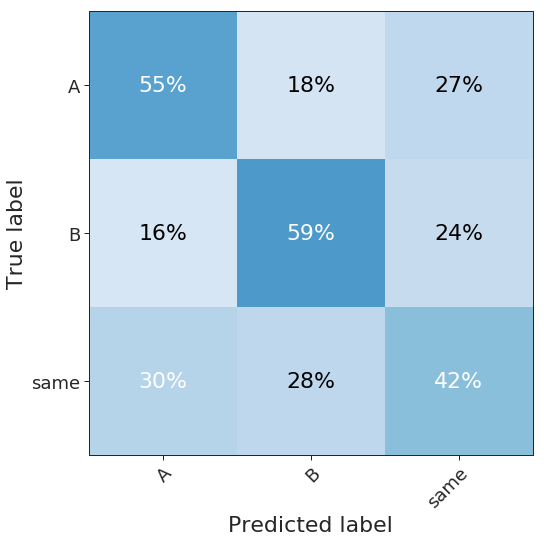

In [7]:
import joblib
from isaac.dataset import read_dataset, prepare_dataset

scaler = joblib.load("scalers/passive_dual_scaler.sk")

model = MultiBranchModel(len(BASIC_TRAINING_COLS), 25, 3)
model.load_state_dict(torch.load("models/passive_mass_dual_model.pt"))
model.eval()
model = model.cuda()

question_type = "mass"

exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp1_trials = [trial[:1801] for trial in exp1_trials]
mass_trials = read_dataset("data/mass_trials_exp2.h5")
force_trials = read_dataset("data/force_trials_exp2.h5")

all_trials = exp1_trials + mass_trials + force_trials

test_loader, _ = prepare_dataset([all_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                 training_columns=BASIC_TRAINING_COLS, multiclass=True, scaler=scaler,
                                 normalise_data=True)
mass_accuracy, _, mass_predicted, _ = evaluate(model, test_loader, return_predicted=True, seq_end=1800, step_size=3)
print(mass_accuracy)
plot(mass_predicted, 0, MASS_CLASS_COLS, test_loader)
plt.savefig(directory+"yoked_data_"+question_type+"_model_cm.pdf")
plt.show()

100%|██████████| 1017/1017 [00:01<00:00, 769.28it/s]


41.98623402163225


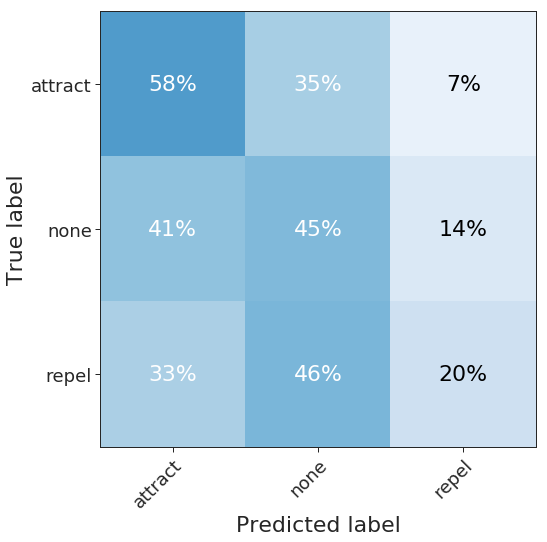

In [8]:
model = MultiBranchModel(len(BASIC_TRAINING_COLS), 25, 3)
model.load_state_dict(torch.load("models/passive_force_dual_model.pt"))
model.eval()
model = model.cuda()

question_type = "force"

exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp1_trials = [trial[:1801] for trial in exp1_trials]
mass_trials = read_dataset("data/mass_trials_exp2.h5")
force_trials = read_dataset("data/force_trials_exp2.h5")

all_trials = exp1_trials + mass_trials + force_trials

test_loader, _ = prepare_dataset([all_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                 training_columns=BASIC_TRAINING_COLS, multiclass=True, scaler=scaler,
                                 normalise_data=True)
_, force_accuracy, _, force_predicted = evaluate(model, test_loader, return_predicted=True, seq_end=1800, step_size=3)
print(force_accuracy)
plot(force_predicted, 1, FORCE_CLASS_COLS, test_loader)
plt.savefig(directory+"yoked_data_"+question_type+"_model_cm.pdf")
plt.show()